[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Annualized Total Strategy Return: 7.31%
Sharpe Ratio: 0.49
Alpha: -0.0439
Beta: 0.0153


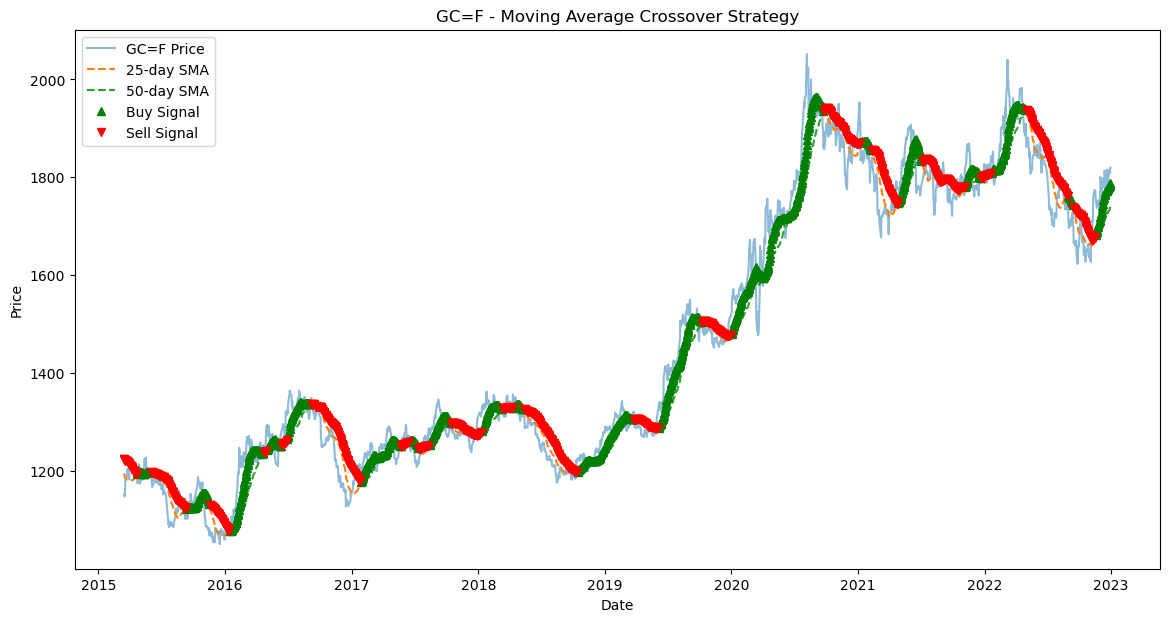

In [23]:
# Commodity Trading Strategy in Python with Alpha and Beta

## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

symbol = 'GC=F'  # Gold Futures
data = yf.download(symbol, start='2015-01-01', end='2023-01-01')
data = data[['Adj Close']].copy()  # Explicitly make a copy to avoid slicing issues
data.rename(columns={'Adj Close': 'price'}, inplace=True)

short_time = 25
long_time = 50

benchmark_symbol = 'SPY'  # S&P 500 ETF as a proxy
benchmark_data = yf.download(benchmark_symbol, start='2015-01-01', end='2023-01-01')
benchmark_data = benchmark_data[['Adj Close']].copy()  # Explicitly make a copy to avoid slicing issues
benchmark_data.rename(columns={'Adj Close': 'benchmark_price'}, inplace=True)

data = data.merge(benchmark_data, left_index=True, right_index=True)

data['SMA_short'] = data['price'].rolling(window=short_time).mean()
data['SMA_long'] = data['price'].rolling(window=long_time).mean()
data['signal'] = 0  # Initialize signal column
data.iloc[short_time:, data.columns.get_loc('signal')] = np.where(data['SMA_short'][short_time:] > data['SMA_long'][short_time:], 1, -1)
data['strategy_return'] = data['signal'].shift(1) * data['price'].pct_change()
data['cumulative_return'] = (1 + data['strategy_return']).cumprod() - 1
data['benchmark_return'] = data['benchmark_price'].pct_change()
data['excess_return'] = data['strategy_return'] - data['benchmark_return']
data = data.dropna()

covariance = np.cov(data['strategy_return'], data['benchmark_return'])[0, 1]
variance = np.var(data['benchmark_return'])
beta = covariance / variance
alpha = data['excess_return'].mean() * 252  # Annualizing the daily alpha
sharpe_ratio = data['strategy_return'].mean() / data['strategy_return'].std() * np.sqrt(252)
trading_days = len(data)

total_cumulative_return = data['cumulative_return'].iloc[-1]
annualized_total_return = (1 + total_cumulative_return) ** (252 / trading_days) - 1

print(f"Annualized Total Strategy Return: {annualized_total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")

plt.figure(figsize=(14, 7))
plt.plot(data['price'], label=f'{symbol} Price', alpha=0.5)
plt.plot(data['SMA_short'], label=f'{short_time}-day SMA', linestyle='--')
plt.plot(data['SMA_long'], label=f'{long_time}-day SMA', linestyle='--')
plt.plot(data[data['signal'] == 1].index, data['SMA_short'][data['signal'] == 1], '^', color='g', label='Buy Signal')
plt.plot(data[data['signal'] == -1].index, data['SMA_long'][data['signal'] == -1], 'v', color='r', label='Sell Signal')
plt.title(f'{symbol} - Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
